In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [3]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('final_data.csv')

In [4]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [5]:
# Split the dataset into training(%80) and test(%20) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(22684, 42) (5672, 42)


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_train_pred_mean = [y_train.mean()] * len(y_train)
y_test_pred_mean  = [y_train.mean()] * len(y_test)

print("BASELINE (train): MAE, RMSE, R2 =",
      mean_absolute_error(y_train, y_train_pred_mean),
      np.sqrt(mean_squared_error(y_train, y_train_pred_mean)),
      r2_score(y_train, y_train_pred_mean))

print("BASELINE (test): MAE, RMSE, R2 =",
      mean_absolute_error(y_test, y_test_pred_mean),
      np.sqrt(mean_squared_error(y_test, y_test_pred_mean)),
      r2_score(y_test, y_test_pred_mean))

BASELINE (train): MAE, RMSE, R2 = 19.8936972829277 23.690550511863467 0.0
BASELINE (test): MAE, RMSE, R2 = 19.914148711219504 23.747533757202742 -3.851367790019822e-06


In [7]:
# Implementation of Base Lasso Regression model
lasso_base = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso_base.fit(X_train, y_train)

preds_val = lasso_base.predict(X_test)

mae = mean_absolute_error(y_test, preds_val)
mse = mean_squared_error(y_test, preds_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds_val)

print("Base Test MAE:", mae)
print("Base Test RMSE:", rmse)
print("Base Test R²:", r2)

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "coef": lasso_base.coef_
})

# keep only non-zero
nonzero = feature_importance[feature_importance["coef"] != 0]
nonzero = nonzero.sort_values(by="coef", ascending=False)

nonzero.head(20)

Base Test MAE: 12.587376457216772
Base Test RMSE: 16.431654321904713
Base Test R²: 0.5212296740295349


,feature,coef
36,artist_avg_popularity,63.229854
11,playlist_count,5.847843


In [8]:
param_grid = {
    "alpha": np.logspace(-3, 2, 10)  # 0.001–100 arası
}

lasso = Lasso(random_state=42, max_iter=5000)

grid_lasso = GridSearchCV(
    lasso,
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_lasso.fit(X_train, y_train)

print("Best alpha:", grid_lasso.best_params_)
print("Best CV MAE:", -grid_lasso.best_score_)

Best alpha: {'alpha': np.float64(0.046415888336127795)}
Best CV MAE: 10.422793436092757


In [9]:
results = pd.DataFrame(grid_lasso.cv_results_)
# print(results)

results["alpha"] = results["param_alpha"].astype(float)
results["mean_MAE"] = -results["mean_test_score"]

# Sort by best performance
results_sorted = results.sort_values("rank_test_score")
print(results_sorted[[
    "alpha", "mean_MAE", "rank_test_score"
]].head(10))

        alpha   mean_MAE  rank_test_score
3    0.046416  10.422793                1
2    0.012915  10.479759                2
1    0.003594  10.519796                3
0    0.001000  10.533963                4
4    0.166810  10.639198                5
5    0.599484  11.588133                6
6    2.154435  16.382060                7
7    7.742637  19.892136                8
8   27.825594  19.895021                9
9  100.000000  19.895021                9


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


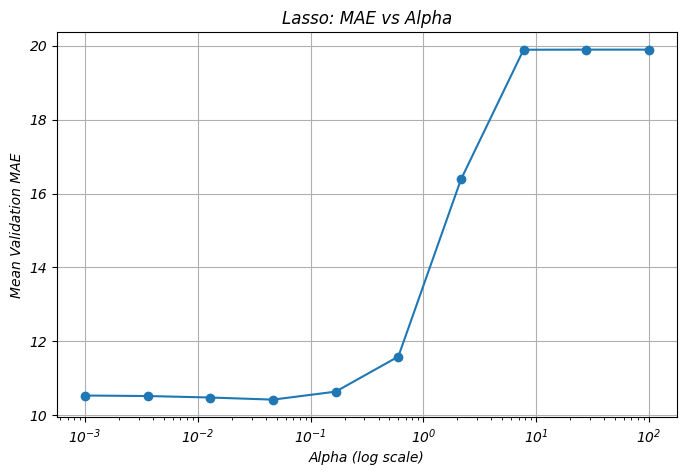

In [10]:
# MAE vs Alpha plot
plt.figure(figsize=(8,5))
results_alpha = results.groupby("alpha")["mean_MAE"].mean().reset_index()

plt.plot(results_alpha["alpha"], results_alpha["mean_MAE"], marker="o")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Validation MAE")
plt.title("Lasso: MAE vs Alpha")
plt.grid(True)
plt.show()

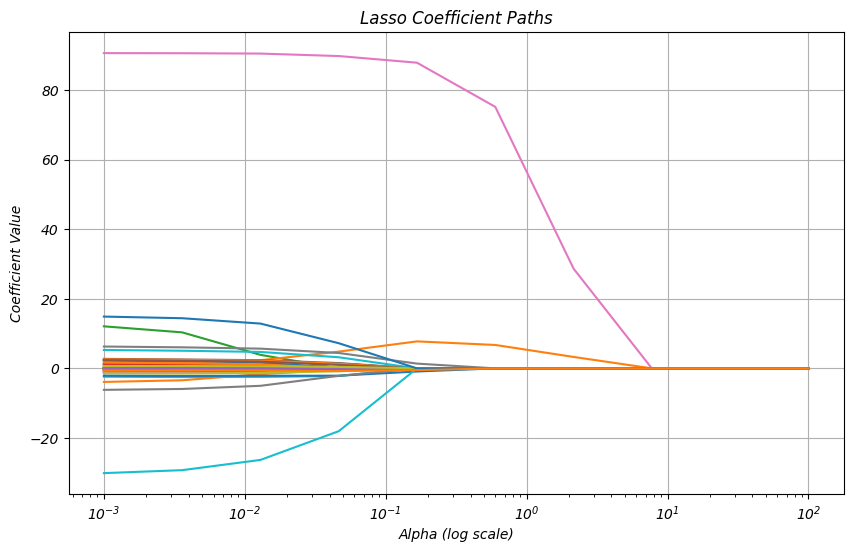

In [12]:
# Coefficient shrinkage plot
alphas = np.logspace(-3, 2, 10)
coefs = []

for a in alphas:
    l = Lasso(alpha=a, max_iter=3000, random_state=42)
    l.fit(X_train, y_train)
    coefs.append(l.coef_)

plt.figure(figsize=(10,6))

for i in range(X.shape[1]):
    plt.plot(alphas, [coef[i] for coef in coefs])

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Coefficient Paths")
plt.grid(True)
plt.show()

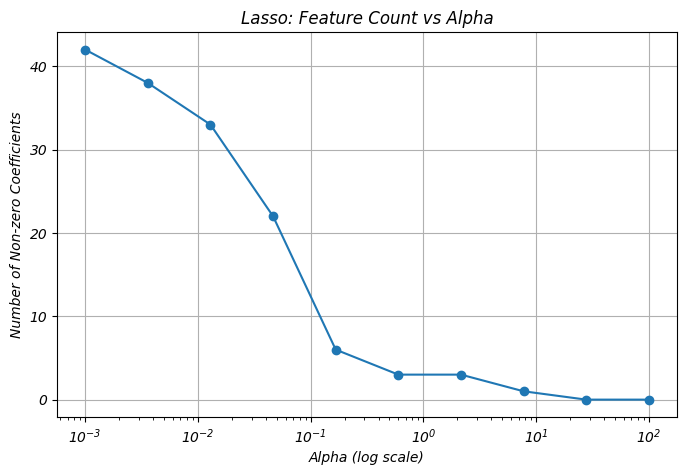

In [13]:
# Number of non-zero coefficients vs Alpha plot
nonzero_counts = [np.sum(np.array(c) != 0) for c in coefs]

plt.figure(figsize=(8,5))
plt.plot(alphas, nonzero_counts, marker="o")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Lasso: Feature Count vs Alpha")
plt.grid(True)
plt.show()


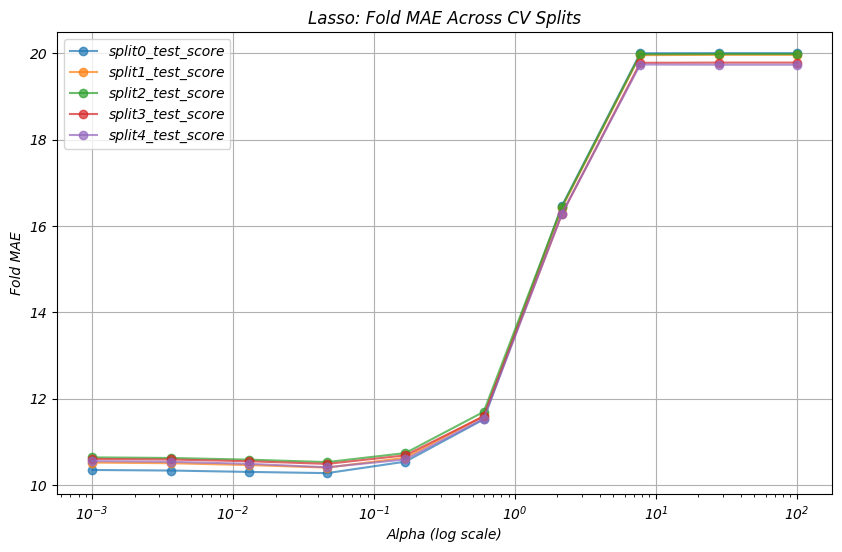

In [14]:
# MAE across CV folds
fold_cols = [col for col in results.columns if "split" in col and "test_score" in col]

mae_folds = results[["alpha"] + fold_cols].copy()

for col in fold_cols:
    mae_folds[col] = -mae_folds[col]  # convert to positive MAE

plt.figure(figsize=(10,6))

for col in fold_cols:
    plt.plot(mae_folds["alpha"], mae_folds[col], marker="o", alpha=0.7, label=col)

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Fold MAE")
plt.title("Lasso: Fold MAE Across CV Splits")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
best_lasso = grid_lasso.best_estimator_

Top Features Selected by Lasso:
                               feature       coef
36               artist_avg_popularity  89.820300
40                playlist_count_final   7.240816
11                      playlist_count   4.822264
27             subgenre_permanent wave   4.425641
29              subgenre_post-teen pop   3.198395
15                  subgenre_dance pop   1.525631
20                    subgenre_hip hop   1.373344
21                    subgenre_hip pop   1.338781
35         subgenre_urban contemporary   0.998551
38                           album_age   0.420600
0                         danceability   0.219853
31                  subgenre_reggaeton   0.030133
13                   subgenre_big room  -0.252825
1                               energy  -0.366260
6                     instrumentalness  -0.433282
26             subgenre_new jack swing  -0.494914
41             artist_song_count_final  -0.754327
28                    subgenre_pop edm  -0.839684
30  subgenre_progr

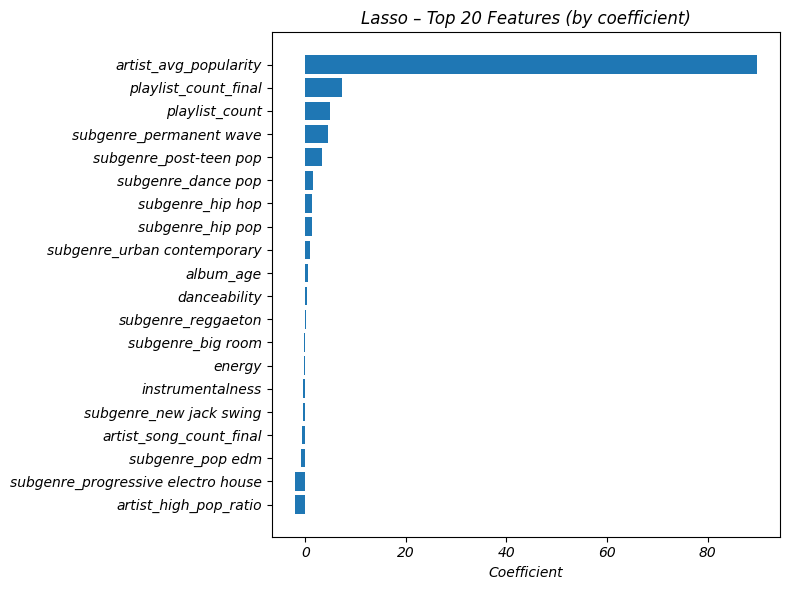

In [16]:
# Feature importance from the best model
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": best_lasso.coef_
})

nonzero_features = feature_importance[feature_importance["coef"] != 0]
nonzero_features = nonzero_features.sort_values(by="coef", ascending=False)

print("Top Features Selected by Lasso:")
print(nonzero_features.head(20))

plt.figure(figsize=(8,6))
plt.barh(nonzero_features["feature"].head(20),
         nonzero_features["coef"].head(20))
plt.gca().invert_yaxis()
plt.xlabel("Coefficient")
plt.title("Lasso – Top 20 Features (by coefficient)")
plt.tight_layout()
plt.show()

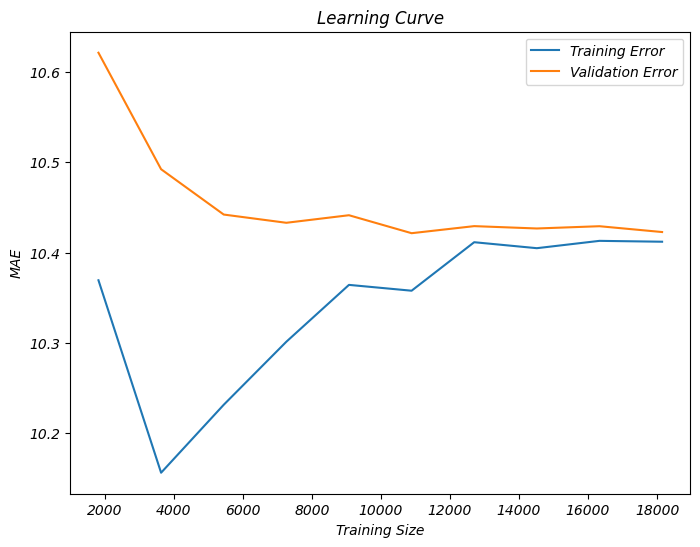

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_lasso.best_estimator_,
    X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label="Training Error")
plt.plot(train_sizes, -val_scores.mean(axis=1), label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("MAE")
plt.legend()
plt.title("Learning Curve")
plt.show()


In [18]:
# ---------- PERFORMANCE ON TEST SET (NO REFIT) ----------
y_pred_test = best_lasso.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print("\n=== LASSO – TEST PERFORMANCE ===")
print("MAE :", test_mae)
print("RMSE:", test_rmse)
print("R²  :", test_r2)


=== LASSO – TEST PERFORMANCE ===
MAE : 10.30474537977434
RMSE: 15.155458406813406
R²  : 0.5927108890180486
